In [2]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize  # Importing minimize function


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred

# -------------------------------------------------- (1) Collect Historical Data -------------------------------------------------- #
# Pull asset data from Yahoo Finance
tickers = ['SPY', 'IWM', 'TLT', 'LQD', 'SHV']
data = yf.download(tickers, start='2012-01-01', end='2024-09-09')
prices = data['Adj Close']

# Calculate daily returns
asset_returns = prices.pct_change().dropna()

# Display the first few rows of the returns
# print(asset_returns.head())

import pandas_datareader.data as web

# Pull Fama-French 5-factor data + Momentum from Kenneth French's Data Library
ff_factors = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start='2012-01-01', end='2024-09-09')[0]
momentum_factors = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start='2012-01-01', end='2024-09-09')[0]

# Pull interest rates and volatility data from FRED
interest_rates_10y = web.DataReader('DGS10', 'fred', start='2012-01-01', end='2024-09-09').dropna()
risk_free_rate = web.DataReader('TB3MS', 'fred', start='2012-01-01', end='2024-09-09').resample('D').ffill()

vix_data = yf.download('^VIX', start='2012-01-01', end='2024-09-09')['Adj Close'].pct_change().dropna()
bond_spreads = web.DataReader('BAMLH0A0HYM2', 'fred', start='2012-01-01', end='2024-09-09').dropna()

# Combine factors
factors = ff_factors.join([momentum_factors, interest_rates_10y, risk_free_rate, vix_data, bond_spreads], how='inner')
factors.columns = ['Mkt-RF', 'SMB', 'HML', 'RF', 'MOM', 'InterestRate_10y', 'RiskFree_3mo', 'VIX', 'Liquidity']

# print(factors.head())


In [ ]:
# ------------------------------------------------ (2) Align Data and Split Dataset ------------------------------------------------ #
# Align asset returns and factor data
# Ensure both asset_returns and factors are tz-naive (no timezone information)
asset_returns.index = asset_returns.index.tz_localize(None)
factors.index = factors.index.tz_localize(None)

# Now you can join the two dataframes without issue
aligned_data = asset_returns.join(factors, how='inner')

# Split data into training and validation sets
train_data = aligned_data.loc['2012-01-01':'2022-06-30']  # Training set
valid_data = aligned_data.loc['2022-07-01':'2023-09-01']  # Validation set
test_data = aligned_data.loc['2023-09-02':'2024-09-01']  # Validation set

print("Training data head:")
display(train_data.head())

print("Validation data head:")
display(valid_data.head())

display(test_data.head())

Training data head:


,IWM,LQD,SHV,SPY,TLT,Mkt-RF,SMB,HML,RF,MOM,InterestRate_10y,RiskFree_3mo,VIX,Liquidity
2012-01-04,-0.005469,0.000792,0.000000,0.001568,-0.011890,0.00,-0.65,0.03,0.0,0.13,2.00,0.03,-0.032651,7.00
2012-01-05,0.005633,-0.004308,0.000000,0.002663,-0.001779,0.39,0.18,0.19,0.0,-0.61,2.02,0.03,-0.033303,7.00
2012-01-06,-0.002533,0.003884,0.000091,-0.002577,0.007895,-0.19,0.02,-0.27,0.0,-0.07,1.98,0.03,-0.039572,7.00
2012-01-09,0.005081,-0.001495,0.000091,0.002428,-0.001769,0.28,0.23,-0.06,0.0,-0.36,1.98,0.03,0.021328,6.99
2012-01-10,0.014633,0.002818,0.000000,0.008670,-0.001687,0.97,0.37,0.38,0.0,-1.10,2.00,0.03,-0.018035,6.92


Validation data head:


,IWM,LQD,SHV,SPY,TLT,Mkt-RF,SMB,HML,RF,MOM,InterestRate_10y,RiskFree_3mo,VIX,Liquidity
2022-07-01,0.012104,0.012640,-0.000027,0.010577,0.010267,1.14,0.02,0.11,0.004,-1.12,2.88,2.23,-0.070010,5.92
2022-07-05,0.008284,-0.000270,0.000091,0.001889,0.007857,0.48,1.82,-3.35,0.004,-4.79,2.82,2.23,0.031461,5.99
2022-07-06,-0.007406,-0.004951,0.000091,0.003377,-0.016791,0.17,-0.75,-0.73,0.004,0.28,2.93,2.23,-0.029412,5.80
2022-07-07,0.023666,-0.000091,0.000000,0.014977,-0.008800,1.77,1.00,-0.96,0.004,-0.99,3.01,2.23,-0.024317,5.50
2022-07-08,-0.000114,-0.001628,-0.000182,-0.000823,-0.011076,-0.07,0.11,-0.07,0.004,0.47,3.09,2.23,-0.055215,5.36


,IWM,LQD,SHV,SPY,TLT,Mkt-RF,SMB,HML,RF,MOM,InterestRate_10y,RiskFree_3mo,VIX,Liquidity
2023-09-05,-0.021064,-0.007141,0.000000,-0.004322,-0.014022,-0.54,-1.36,-0.86,0.021,-0.37,4.27,5.32,0.070283,3.83
2023-09-06,-0.003747,-0.000959,0.000182,-0.006723,0.002459,-0.71,-0.01,-0.18,0.021,0.73,4.30,5.32,0.031406,3.86
2023-09-07,-0.009671,0.004415,0.000545,-0.003070,0.002774,-0.40,-0.63,0.03,0.021,0.12,4.27,5.32,-0.003460,3.90
2023-09-08,-0.002224,0.000764,0.000091,0.001506,0.003829,0.12,-0.61,0.40,0.021,0.07,4.26,5.32,-0.038889,3.85
2023-09-11,0.002392,-0.001910,0.000182,0.006577,-0.007206,0.66,-0.26,-0.54,0.021,-0.48,4.29,5.32,-0.002890,3.82


In [ ]:
# -------------------------------------------- (3) Build Factor Model on Training Data -------------------------------------------- #
# Define factors (independent variables) for the training set
X_train = train_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'VIX', 'Liquidity', 'InterestRate_10y']]
X_train = sm.add_constant(X_train)  # Add constant for intercept

# Run the regression for each asset individually
factor_loadings = {}
for asset in ['SPY', 'IWM', 'TLT', 'LQD', 'SHV']:
    Y_train = train_data[asset]  # Asset returns for the specific asset
    model_train = sm.OLS(Y_train, X_train).fit()  # Run regression
    factor_loadings[asset] = model_train.params  # Store factor loadings
    print(f"Results for {asset}:")
    print(model_train.summary())  # Print the summary of each regression


Results for SPY:
                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 7.018e+04
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:27:00   Log-Likelihood:                 15079.
No. Observations:                2619   AIC:                        -3.014e+04
Df Residuals:                    2611   BIC:                        -3.010e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.

In [ ]:
# Function to create individual tables for each factor with coefficients for all assets
def create_factor_table(factor_name):
    factor_table = pd.DataFrame({asset: factor_loadings[asset][factor_name] for asset in factor_loadings.keys()},
                                index=[factor_name])
    return factor_table

# Generate tables for each factor
factors = ['Mkt-RF', 'SMB', 'HML', 'MOM', 'VIX', 'Liquidity', 'InterestRate_10y']
tables = {}

for factor in factors:
    tables[factor] = create_factor_table(factor)

# Display the tables one by one
for factor, table in tables.items():
    print(f"Table for {factor}:")
    print(table)
    print("\n")

Table for Mkt-RF:
            SPY       IWM       TLT       LQD       SHV
Mkt-RF  0.00963  0.010065 -0.002732  0.001101 -0.000016


Table for SMB:
          SPY       IWM       TLT       LQD       SHV
SMB -0.001366  0.008503  0.000337 -0.000173 -0.000002


Table for HML:
          SPY       IWM       TLT       LQD       SHV
HML  0.000214  0.002016 -0.002746 -0.000784 -0.000019


Table for MOM:
          SPY       IWM       TLT       LQD       SHV
MOM -0.000057 -0.000102  0.000191 -0.000074 -0.000004


Table for VIX:
          SPY      IWM       TLT      LQD       SHV
VIX -0.001685 -0.00193  0.003068  0.00601 -0.000026


Table for Liquidity:
               SPY       IWM      TLT       LQD       SHV
Liquidity -0.00002  0.000008  0.00026  0.000222 -0.000002


Table for InterestRate_10y:
                       SPY       IWM       TLT       LQD       SHV
InterestRate_10y  0.000007  0.000129 -0.000404 -0.000106  0.000009




In [ ]:

# ------------------------------------------- (4) Validate Factor Model on Validate Data ------------------------------------------- #
# Define factors for the validation set
X_valid = valid_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'VIX', 'Liquidity', 'InterestRate_10y']]
X_valid = sm.add_constant(X_valid)  # Add constant for intercept

# Initialize dictionaries to store predictions and MSE results
predicted_returns = {}
mse_results = {}

# Predict returns and calculate MSE for each asset
for asset in ['SPY', 'IWM', 'TLT', 'LQD', 'SHV']:
    # Use the trained model for each asset to predict returns
    Y_valid = valid_data[asset]

    # Run the regression model for this asset on training data (reusing the training model for each)
    model_train = sm.OLS(train_data[asset], sm.add_constant(train_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'VIX', 'Liquidity', 'InterestRate_10y']])).fit()

    # Predict returns using the validation data
    predicted_returns[asset] = model_train.predict(X_valid)

    # Calculate Mean Squared Error (MSE) for the validation data
    mse_results[asset] = mean_squared_error(Y_valid, predicted_returns[asset])

    # Print predicted and actual returns comparison for validation set
    print(f"Predicted Returns for {asset} on Validation Set:")
    print(predicted_returns[asset].head())

    print(f"Actual Returns for {asset} on Validation Set:")
    print(Y_valid.head())




Predicted Returns for SPY on Validation Set:
2022-07-01    0.011180
2022-07-05    0.001661
2022-07-06    0.002566
2022-07-07    0.015604
2022-07-08   -0.000737
dtype: float64
Actual Returns for SPY on Validation Set:
2022-07-01    0.010577
2022-07-05    0.001889
2022-07-06    0.003377
2022-07-07    0.014977
2022-07-08   -0.000823
Name: SPY, dtype: float64
Predicted Returns for IWM on Validation Set:
2022-07-01    0.012191
2022-07-05    0.014047
2022-07-06   -0.006028
2022-07-07    0.024619
2022-07-08    0.000248
dtype: float64
Actual Returns for IWM on Validation Set:
2022-07-01    0.012104
2022-07-05    0.008284
2022-07-06   -0.007406
2022-07-07    0.023666
2022-07-08   -0.000114
Name: IWM, dtype: float64
Predicted Returns for TLT on Validation Set:
2022-07-01   -0.003582
2022-07-05    0.007982
2022-07-06    0.001455
2022-07-07   -0.002032
2022-07-08    0.000367
dtype: float64
Actual Returns for TLT on Validation Set:
2022-07-01    0.010267
2022-07-05    0.007857
2022-07-06   -0.01679

In [ ]:
# Display the MSE results for each asset
print("Mean Squared Error (MSE) for each asset:")
for asset, mse in mse_results.items():
    print(f"{asset}: {mse}")

Mean Squared Error (MSE) for each asset:
SPY: 6.136918340001775e-07
IWM: 4.168952531133294e-06
TLT: 0.00015206742621718392
LQD: 4.024270128603496e-05
SHV: 5.362561489784119e-08


In [ ]:
# ------------------------------------- (5) Calculate Expected Returns Based on Factor Model ------------------------------------- #
# Calculate the average returns of the factors (from training data)
factor_returns = train_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'VIX', 'Liquidity', 'InterestRate_10y']].mean()

# Initialize dictionary to store annualized expected returns for each asset
annualized_expected_returns = {}

# Use the trained model to calculate expected returns for each asset
for asset in ['SPY', 'IWM', 'TLT', 'LQD', 'SHV']:
    # Get the trained factor model for each asset
    model_train = sm.OLS(train_data[asset], sm.add_constant(train_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'VIX', 'Liquidity', 'InterestRate_10y']])).fit()

    # Calculate expected return as: alpha + sum(beta * factor_return)
    expected_return = model_train.params['const'] + (model_train.params[1:] * factor_returns).sum()

    # Annualize the expected return (multiply daily expected return by 252 trading days)
    annualized_expected_returns[asset] = expected_return * 252

# Print the annualized expected returns
print("Annualized Expected Returns:")
print(annualized_expected_returns)


Annualized Expected Returns:
{'SPY': 0.13864503436963002, 'IWM': 0.11495382672579625, 'TLT': 0.029624550601169457, 'LQD': 0.03204030974449393, 'SHV': 0.005400010503275885}


In [ ]:
expected_returns = np.array(list(annualized_expected_returns.values()))
expected_returns

array([0.13864503, 0.11495383, 0.02962455, 0.03204031, 0.00540001])

In [ ]:
# ------------------------------------------- (6) Dynamic Factor Weights Based on Regression Priority ------------------------------------------ #
# Adjust factor weights based on regression results (priority-based adjustment)
def adjust_factor_weights_based_on_regression(model_params):
    adjusted_weights = {}
    # Adjusting based on the priority of the regression coefficients
    for factor in model_params.index[1:]:
        # Prioritize high betas (factor loadings)
        if model_params[factor] > 0.5:
            adjusted_weights[factor] = model_params[factor] * 1.5
        elif model_params[factor] > 0.2:
            adjusted_weights[factor] = model_params[factor] * 1.2
        else:
            adjusted_weights[factor] = model_params[factor] * 1.0
    return adjusted_weights


In [ ]:
factor_loadings

{'SPY': const               0.000122
 Mkt-RF              0.009630
 SMB                -0.001366
 HML                 0.000214
 MOM                -0.000057
 VIX                -0.001685
 Liquidity          -0.000020
 InterestRate_10y    0.000007
 dtype: float64,
 'IWM': const              -0.000341
 Mkt-RF              0.010065
 SMB                 0.008503
 HML                 0.002016
 MOM                -0.000102
 VIX                -0.001930
 Liquidity           0.000008
 InterestRate_10y    0.000129
 dtype: float64,
 'TLT': const              -0.000121
 Mkt-RF             -0.002732
 SMB                 0.000337
 HML                -0.002746
 MOM                 0.000191
 VIX                 0.003068
 Liquidity           0.000260
 InterestRate_10y   -0.000404
 dtype: float64,
 'LQD': const              -0.000758
 Mkt-RF              0.001101
 SMB                -0.000173
 HML                -0.000784
 MOM                -0.000074
 VIX                 0.006010
 Liquidity           

In [ ]:
def normalize_client_weights(client_factor_weights, factor_risks):
    from collections import defaultdict
    factor_maximum = defaultdict(int)
    for i, asset in enumerate(factor_risks.keys()):
        for factor in client_factor_weights.keys():
            factor_maximum[factor] = max(factor_maximum[factor], abs(factor_risks[asset][factor]))
    ret = {}
    for asset, client_weight in client_factor_weights.items():
        ret[asset] = client_weight * factor_maximum[asset];
    return ret

normalize_client_weights({
    'Mkt-RF': 0.20,
    'SMB': 0.15,
    'HML': 0.25,
    'MOM': 0.10,
    'VIX': 0.15,
    'Liquidity': 0.05,
    'InterestRate_10y': 0.10
}, factor_loadings)


{'Mkt-RF': 0.0020129080059260725,
 'SMB': 0.0012753867922050295,
 'HML': 0.0006863947667661704,
 'MOM': 1.905119664358556e-05,
 'VIX': 0.0009014717080998866,
 'Liquidity': 1.3005915174034926e-05,
 'InterestRate_10y': 4.037842912693289e-05}

In [ ]:
risk_free_rate

,TB3MS
DATE,
2012-01-01,0.03
2012-01-02,0.03
2012-01-03,0.03
2012-01-04,0.03
2012-01-05,0.03
...,...
2024-07-28,5.20
2024-07-29,5.20
2024-07-30,5.20


In [ ]:
risk_free_rate_today = risk_free_rate.iloc[-1].iloc[0] / 100
risk_free_rate_today

0.050499999999999996


Optimizing for Sharpe Weight: 0

Optimizing for Sharpe Weight: 0.0001

Optimizing for Sharpe Weight: 0.0002

Optimizing for Sharpe Weight: 0.0004

Optimizing for Sharpe Weight: 0.0005

Optimizing for Sharpe Weight: 0.001


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])



Optimizing for Sharpe Weight: 0.002

Optimizing for Sharpe Weight: 0.005

Optimizing for Sharpe Weight: 0.01

Optimizing for Sharpe Weight: 0.05

Optimizing for Sharpe Weight: 0.5

Optimizing for Sharpe Weight: 1

Results for Sharpe Weight	: 0
Optimal Portfolio Weights:	 ['0.08', '0.05', '0.27', '0.05', '0.55']
Expected Portfolio Return:	 0.029355981912149443
Real Portfolio Return:		 0.06820971829248418
Portfolio Volatility (Risk):	 0.04441117332147624
Adjusted Sharpe Ratio:		 -0.4760968131779978

Results for Sharpe Weight	: 0.0001
Optimal Portfolio Weights:	 ['0.19', '0.05', '0.38', '0.05', '0.33']
Expected Portfolio Return:	 0.046815290955441756
Real Portfolio Return:		 0.08574934578056757
Portfolio Volatility (Risk):	 0.06384952501032157
Adjusted Sharpe Ratio:		 -0.057709263208498264

Results for Sharpe Weight	: 0.0002
Optimal Portfolio Weights:	 ['0.27', '0.05', '0.45', '0.05', '0.18']
Expected Portfolio Return:	 0.05888508147245326
Real Portfolio Return:		 0.09807120051307405
Por

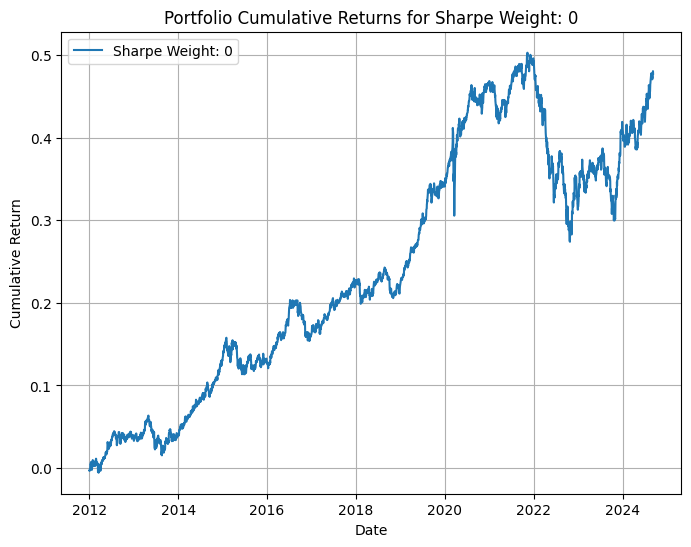

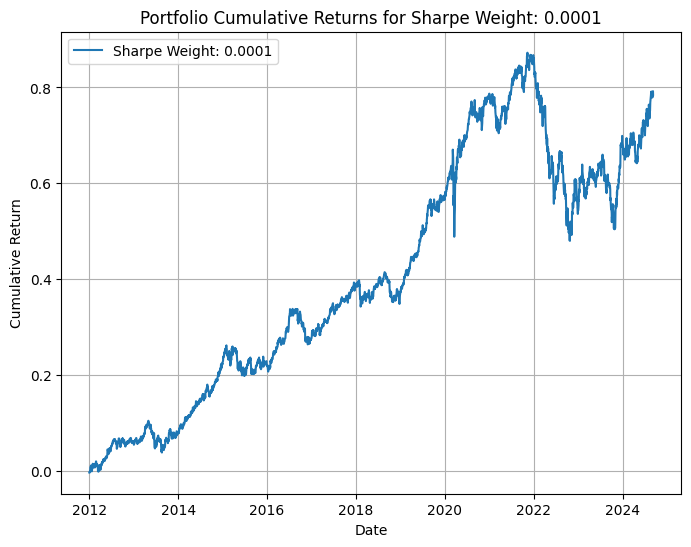

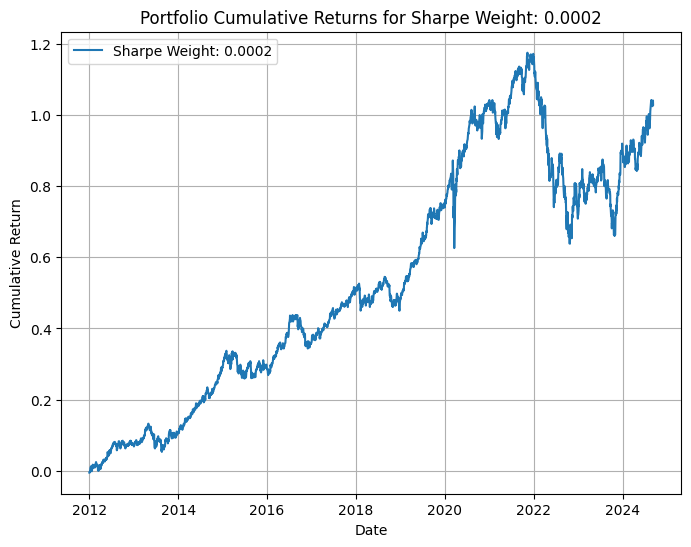

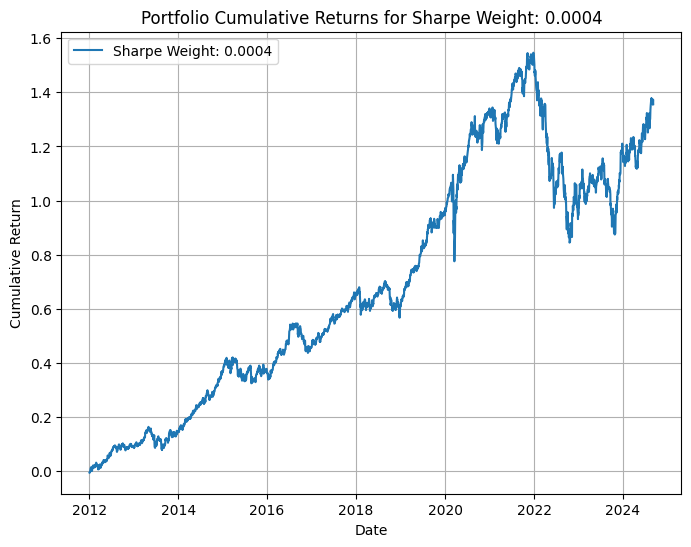

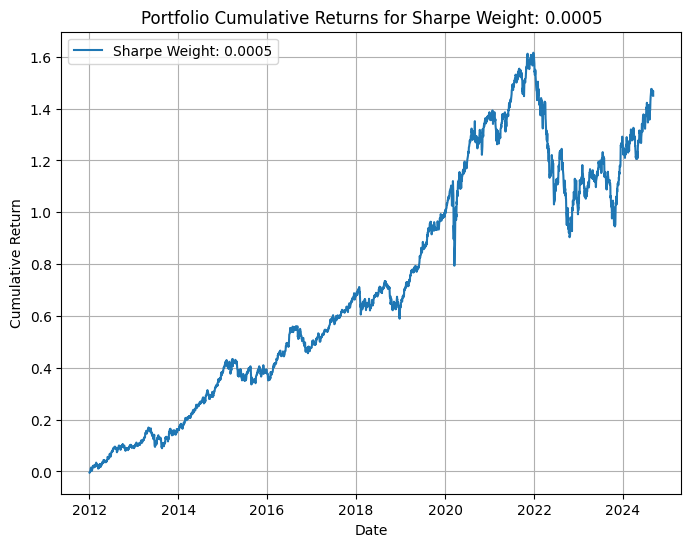

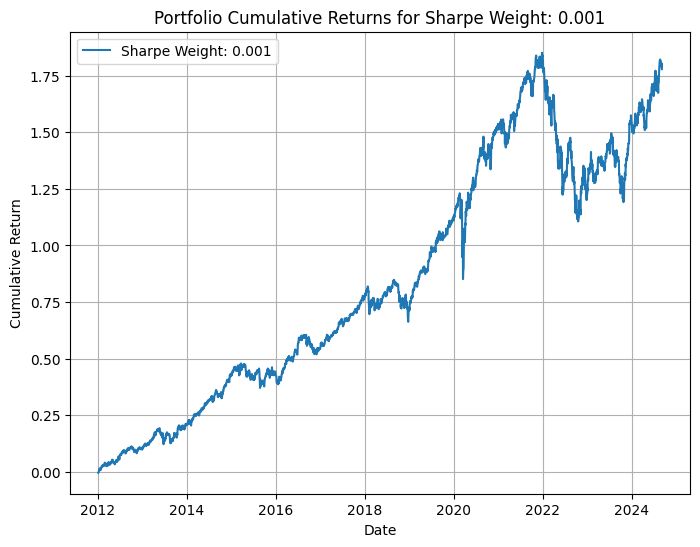

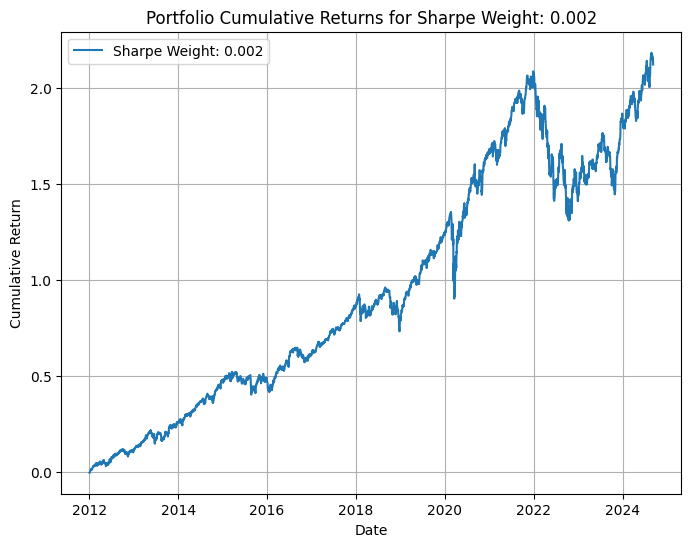

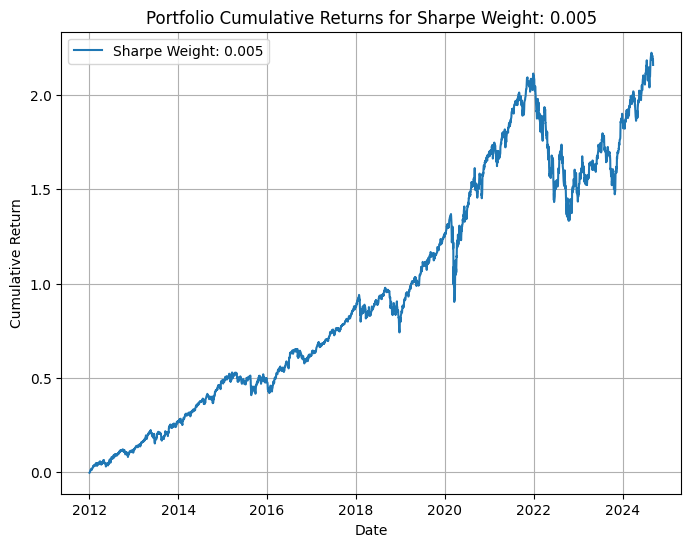

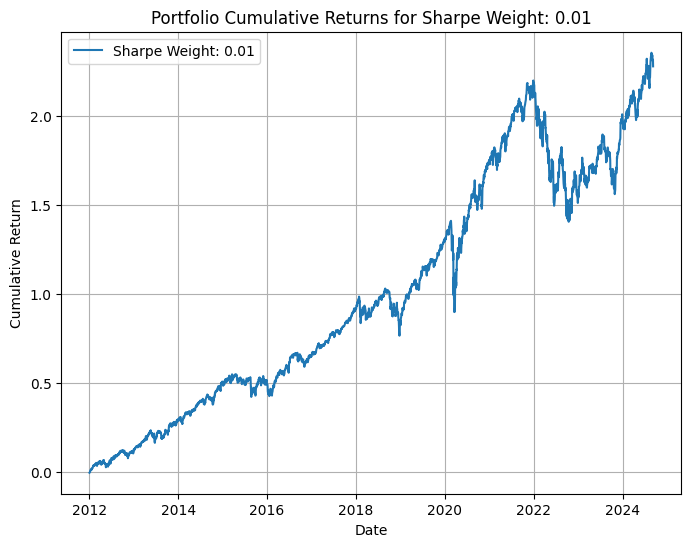

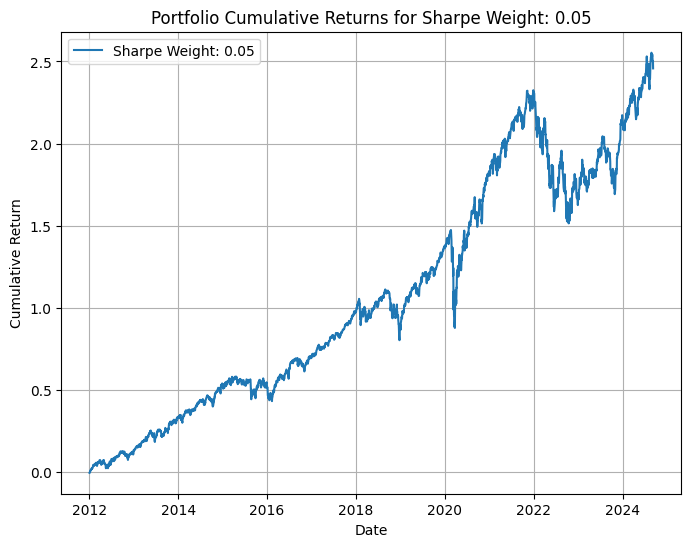

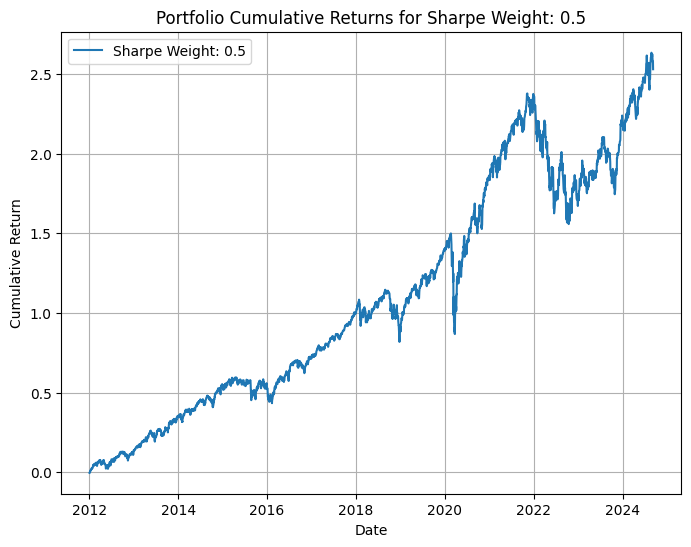

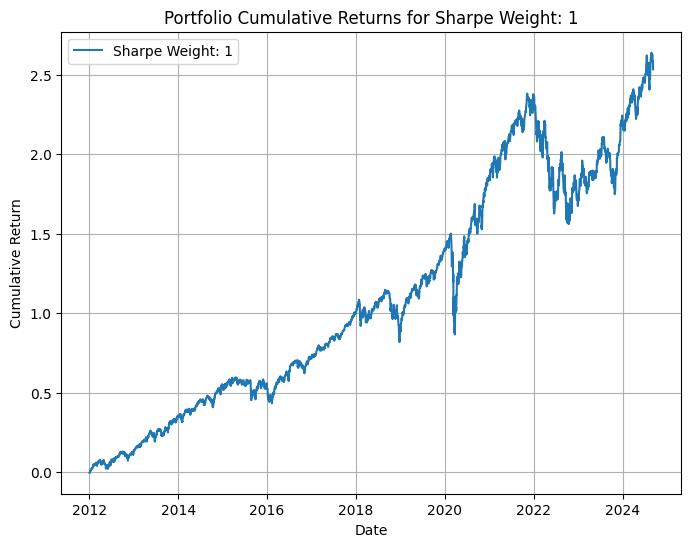

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Example of client-configured factor weights
unnormalized_client_factor_weights = {
    'Mkt-RF': 0.00,
    'SMB': 0.00,
    'HML': 0.00,
    'MOM': 0.00,
    'VIX': 0.00,
    'Liquidity': 0.00,
    'InterestRate_10y': 1.00
}

# Normalize client_factor_weights if necessary
client_factor_weights = normalize_client_weights(unnormalized_client_factor_weights, factor_loadings)

# max_factor = max([abs(x) for f, x in client_factor_weights.items()])
# print(f"max_factor is {max_factor}")
# display(client_factor_weights)

# Sharpe ratio weights to test
sharpe_weights = [0, 0.0001, 0.0002, 0.0004, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05, 0.5, 1]

# Constraints to ensure allocation to each asset class (min/max)
bounds = [(0.05, 0.55) for _ in range(len(expected_returns))]

factor_exposure_penalty = 10

# annualized_avg_risk_free_rate = risk_free_rate.mean() * 252
# print(f"annualized_avg_risk_free_rate = {annualized_avg_risk_free_rate}")
# annualized_risk_free_rate_std = risk_free_rate.std() * np.sqrt(252)

factor_risks = factor_loadings
factors_list = list(client_factor_weights.keys())
asset_returns_subset = asset_returns[['SPY', 'IWM', 'TLT', 'LQD', 'SHV']]  # Filter only the assets of interest
cov_matrix = asset_returns_subset.cov().values  # Get covariance matrix as a NumPy array

real_asset_returns = test_data[['SPY', 'IWM', 'TLT', 'LQD', 'SHV']].mean() * 252

# Define a function to calculate total factor exposures
def calculate_total_factor_exposures(weights, factor_risks, factors_list, doprint=False):
    total_factor_exposures = {factor: 0 for factor in factors_list}

    # Calculate total factor exposures of the portfolio

    for i, asset in enumerate(factor_risks.keys()):
        for factor in factors_list:
            total_factor_exposures[factor] += weights[i] * factor_risks[asset][factor]
    if doprint:
        print_key = "Liquidity"
        print(f"total {print_key} exp {total_factor_exposures[print_key]}")
    return total_factor_exposures

# Define the Adjusted Objective Function
def objective_function(weights, factor_risks, client_factor_weights, factors_list, sharpe_w, doprint=False):
    total_factor_exposures = calculate_total_factor_exposures(weights, factor_risks, factors_list, doprint=doprint)
    total_error = 0
    for factor in client_factor_weights:
        if doprint:
            print(f"factor {factor}\t exposure \t{total_factor_exposures[factor]:.6f} target {client_factor_weights[factor]:.6f}")
        total_error += (total_factor_exposures[factor] - client_factor_weights[factor]) ** 2
    total_error *= factor_exposure_penalty

    # Portfolio return and volatility
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

    # Factor risk adjustment (optional)
    factor_risk_adjustment = 0
    for factor in factors_list:
        factor_risk_adjustment += client_factor_weights[factor] * total_factor_exposures[factor]

    # Adjusted Sharpe Ratio calculation
    adjusted_sharpe = (portfolio_return - risk_free_rate_today) / portfolio_volatility
    return (total_error - adjusted_sharpe * sharpe_w) * 1000

# Define Constraints
def constraint_sum(weights):
    return np.sum(weights) - 1

# Initial guess for weights (equal allocation initially)
init_weights = np.ones(len(expected_returns)) / len(expected_returns)

# Store results for each Sharpe weight
results = []

# Loop through different Sharpe weights
for sharpe_w in sharpe_weights:
    print(f"\nOptimizing for Sharpe Weight: {sharpe_w}")

    # Perform Optimization
    optimized = minimize(
        objective_function,
        init_weights,
        args=(factor_risks, client_factor_weights, factors_list, sharpe_w),
        method='SLSQP',
        bounds=bounds,
        constraints={'type': 'eq', 'fun': constraint_sum}
    )

    # Extract optimal weights
    optimal_weights = optimized.x

    # Portfolio expected return and risk
    expected_portfolio_return = np.dot(optimal_weights, expected_returns)
    real_portfolio_return = np.dot(optimal_weights, real_asset_returns)
    portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(252)

    # Calculate Adjusted Sharpe Ratio
    adjusted_sharpe_ratio = (expected_portfolio_return - risk_free_rate_today) / portfolio_volatility

    # Store result
    results.append({
        'Sharpe Weight': sharpe_w,
        'Optimal Weights': optimal_weights,
        'Expected Return': expected_portfolio_return,
        'Real Return': real_portfolio_return,
        'Volatility': portfolio_volatility,
        'Adjusted Sharpe Ratio': adjusted_sharpe_ratio
    })

# Display results
for result in results:
    print(f"\nResults for Sharpe Weight\t: {result['Sharpe Weight']}")
    print("Optimal Portfolio Weights:\t", ["{0:0.2f}".format(w) for w in result['Optimal Weights']])
    print("Expected Portfolio Return:\t", result['Expected Return'])
    print("Real Portfolio Return:\t\t", result['Real Return'])
    print("Portfolio Volatility (Risk):\t", result['Volatility'])
    print("Adjusted Sharpe Ratio:\t\t", result['Adjusted Sharpe Ratio'])

optimal_weights_list = []

# Optional: Plot Portfolio Cumulative Returns
for result in results:
    sharpe_w = result['Sharpe Weight']
    optimal_weights = result['Optimal Weights']
    optimal_weights_list.append(optimal_weights)

    portfolio_cumulative_returns = (asset_returns_subset.dot(optimal_weights) + 1).cumprod() - 1

    plt.figure(figsize=(8, 6))
    plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label=f"Sharpe Weight: {sharpe_w}")
    plt.title(f'Portfolio Cumulative Returns for Sharpe Weight: {sharpe_w}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
optimal_weights_list

[array([0.07950503, 0.05      , 0.27049497, 0.05      , 0.55      ]),
 array([0.19110802, 0.05      , 0.37736039, 0.05      , 0.33153159]),
 array([0.2688372 , 0.05      , 0.44806406, 0.05      , 0.18309873]),
 array([0.36165609, 0.05      , 0.48834391, 0.05      , 0.05      ]),
 array([0.38674337, 0.05      , 0.46325663, 0.05      , 0.05      ]),
 array([0.46990744, 0.05      , 0.38009256, 0.05      , 0.05      ]),
 array([0.55, 0.05, 0.3 , 0.05, 0.05]),
 array([0.55      , 0.06135716, 0.28864284, 0.05      , 0.05      ]),
 array([0.55      , 0.09869158, 0.25130842, 0.05      , 0.05      ]),
 array([0.55      , 0.15500732, 0.19499268, 0.05      , 0.05      ]),
 array([0.55      , 0.17799595, 0.17200405, 0.05      , 0.05      ]),
 array([0.55      , 0.17954111, 0.17045889, 0.05      , 0.05      ])]

In [ ]:
for optimal_weights in optimal_weights_list:
  objective_function(optimal_weights, factor_risks, client_factor_weights, factors_list, sharpe_w, doprint=True)
  print("")

total Liquidity exp 7.891805873379318e-05
factor Mkt-RF	 exposure 	0.000576 target 0.000000
factor SMB	 exposure 	0.000398 target 0.000000
factor HML	 exposure 	-0.000674 target 0.000000
factor MOM	 exposure 	0.000036 target 0.000000
factor VIX	 exposure 	0.000886 target 0.000000
factor Liquidity	 exposure 	0.000079 target 0.000000
factor InterestRate_10y	 exposure 	-0.000103 target 0.000404

total Liquidity exp 0.00010502020690153282
factor Mkt-RF	 exposure 	0.001362 target 0.000000
factor SMB	 exposure 	0.000282 target 0.000000
factor HML	 exposure 	-0.000940 target 0.000000
factor MOM	 exposure 	0.000051 target 0.000000
factor VIX	 exposure 	0.001031 target 0.000000
factor Liquidity	 exposure 	0.000105 target 0.000000
factor InterestRate_10y	 exposure 	-0.000147 target 0.000404

total Liquidity exp 0.00012222149503193102
factor Mkt-RF	 exposure 	0.001920 target 0.000000
factor SMB	 exposure 	0.000200 target 0.000000
factor HML	 exposure 	-0.001115 target 0.000000
factor MOM	 exposur

In [ ]:
real_asset_returns = test_data[['SPY', 'IWM', 'TLT', 'LQD', 'SHV']].mean() * 252
print(real_asset_returns)

SPY    0.236599
IWM    0.206622
TLT    0.023817
LQD    0.077968
SHV    0.052231
dtype: float64


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas_datareader import data as web
import matplotlib.pyplot as plt

# --------------------------- (1) Collect Historical Data for Russell 3000 and Bloomberg Agg ----------------------------- #
tickers_new = ['IWV', 'AGG']  # IWV for Russell 3000 and AGG for Bloomberg Aggregate Bond Index
data_new = yf.download(tickers_new, start='2012-01-01', end='2024-09-09')
prices_new = data_new['Adj Close']

# Calculate daily returns for Russell 3000 and Bloomberg Aggregate Bond
index_returns_new = prices_new.pct_change().dropna()

# --------------------------- (2) Create Blended Portfolio (60% Russell 3000, 40% Bloomberg Agg) ---------------------------- #
portfolio_weights = [0.60, 0.40]  # 60% Russell 3000, 40% Bloomberg Aggregate

# Calculate the weighted portfolio returns
blended_portfolio_returns = index_returns_new.dot(portfolio_weights)

# --------------------------- (3) Collect Market Factors ----------------------------- #
# Pull Fama-French 5-factor data + Momentum from Kenneth French's Data Library
ff_factors = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start='2012-01-01', end='2024-09-09')[0]
momentum_factors = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start='2012-01-01', end='2024-09-09')[0]

# Pull interest rates and volatility data from FRED
interest_rates_10y = web.DataReader('DGS10', 'fred', start='2012-01-01', end='2024-09-09').dropna()
risk_free_rate = web.DataReader('TB3MS', 'fred', start='2012-01-01', end='2024-09-09').resample('D').ffill()

# Pull VIX data from Yahoo Finance and calculate percentage change (proxy for volatility)
vix_data = yf.download('^VIX', start='2012-01-01', end='2024-09-09')['Adj Close'].pct_change().dropna()

# Pull bond spreads from FRED (high-yield bond spreads as a liquidity proxy)
bond_spreads = web.DataReader('BAMLH0A0HYM2', 'fred', start='2012-01-01', end='2024-09-09').dropna()

# --------------------------- (4) Combine Market Factors ----------------------------- #
# Combine all factors into a single DataFrame
factors = ff_factors.join([momentum_factors, interest_rates_10y, risk_free_rate, vix_data, bond_spreads], how='inner')

# Rename the columns for clarity
factors.columns = ['Mkt-RF', 'SMB', 'HML', 'RF', 'MOM', 'InterestRate_10y', 'RiskFree_3mo', 'VIX', 'Liquidity']

# --------------------------- (5) Align Data ----------------------------- #
# Convert both indices to timezone-naive to avoid mismatch
blended_portfolio_returns.index = blended_portfolio_returns.index.tz_localize(None)  # Timezone-naive
factors.index = factors.index.tz_localize(None)  # Timezone-naive

# Ensure portfolio returns are in a DataFrame with a clear column name
blended_portfolio_returns = blended_portfolio_returns.to_frame(name='Portfolio_Return')
print(blended_portfolio_returns)

# Combine portfolio returns with the factors
aligned_data = blended_portfolio_returns.join(factors, how='inner').dropna()


[*********************100%***********************]  2 of 2 completed
<ipython-input-49-5f0e3db894a7>:24: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factors = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start='2012-01-01', end='2024-09-09')[0]
<ipython-input-49-5f0e3db894a7>:25: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  momentum_factors = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start='2012-01-01', end='2024-09-09')[0]
[*********************100%***********************]  1 of 1 completed

            Portfolio_Return
Date                        
2012-01-04         -0.000605
2012-01-05          0.002519
2012-01-06         -0.000356
2012-01-09          0.000358
2012-01-10          0.003698
...                      ...
2024-08-30          0.001809
2024-09-03         -0.005644
2024-09-04          0.001663
2024-09-05          0.000629
2024-09-06         -0.005915

[3189 rows x 1 columns]


In [ ]:

# Now aligned_data should be properly joined without tz-naive vs tz-aware issues

# --------------------------- (6) Perform Regression to Calculate Risk Factor Coefficients ----------------------------- #
# Independent variables (risk factors)
X_factors = aligned_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'InterestRate_10y', 'VIX', 'Liquidity']]

# Dependent variable (portfolio returns)
Y_portfolio = aligned_data['Portfolio_Return']

# Add constant to the model (for alpha)
X_factors = sm.add_constant(X_factors)

# Perform OLS regression
factor_model = sm.OLS(Y_portfolio, X_factors).fit()

# Display regression results (Risk Factor Coefficients)
print(factor_model.summary())


                            OLS Regression Results                            
Dep. Variable:       Portfolio_Return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     2614.
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:27:40   Log-Likelihood:                 15338.
No. Observations:                3139   AIC:                        -3.066e+04
Df Residuals:                    3131   BIC:                        -3.061e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0003      0.000  

In [ ]:
blended_portfolio_returns

,Portfolio_Return
Date,
2012-01-04,-0.000605
2012-01-05,0.002519
2012-01-06,-0.000356
2012-01-09,0.000358
2012-01-10,0.003698
...,...
2024-08-30,0.001809
2024-09-03,-0.005644
2024-09-04,0.001663


In [ ]:
# --------------------------- (7) Calculate Portfolio Metrics ----------------------------- #
# Expected portfolio return (mean of blended portfolio returns)
expected_portfolio_return = blended_portfolio_returns.mean().iloc[0] * 252  # Annualized return
# print(expected_portfolio_return)

Expected Portfolio Return (Annualized): 0.0689
Portfolio Volatility (Annualized): 0.0757
Sharpe Ratio: 0.2435


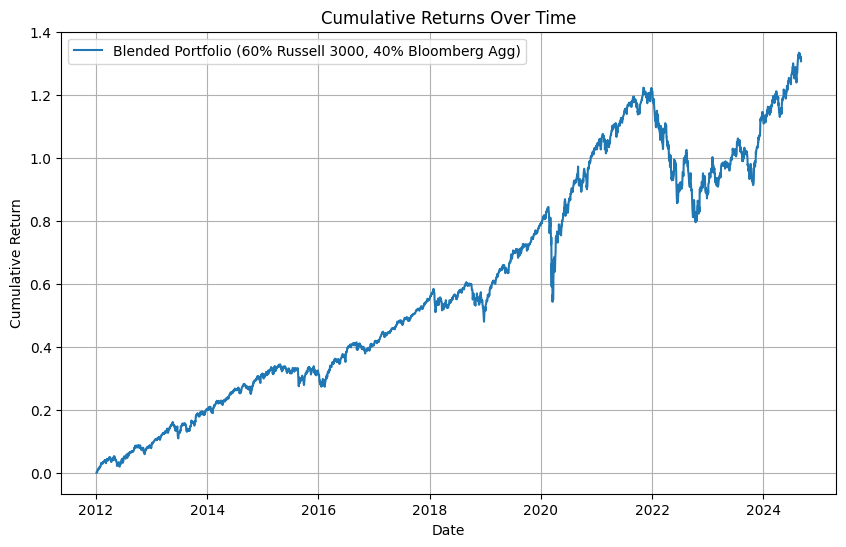

In [ ]:
# Portfolio volatility (standard deviation of blended portfolio returns)
portfolio_volatility = blended_portfolio_returns.std() * np.sqrt(252)  # Annualized volatility
# If portfolio_volatility is a Series or array, use .item() to convert it to a scalar
if isinstance(portfolio_volatility, (pd.Series, np.ndarray)):
    portfolio_volatility = portfolio_volatility.item()
# print(portfolio_volatility)

# Sharpe Ratio for the blended portfolio
sharpe_ratio = (expected_portfolio_return - risk_free_rate_today) / portfolio_volatility
# print(sharpe_ratio)

# --------------------------- (8) Display Portfolio Results ----------------------------- #
# Display the portfolio results
print(f"Expected Portfolio Return (Annualized): {expected_portfolio_return:.4f}")
print(f"Portfolio Volatility (Annualized): {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# --------------------------- (9) Plot Cumulative Returns ----------------------------- #
# Calculate cumulative returns
blended_portfolio_cumulative_returns = (1 + blended_portfolio_returns).cumprod() - 1

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(blended_portfolio_cumulative_returns.index, blended_portfolio_cumulative_returns, label="Blended Portfolio (60% Russell 3000, 40% Bloomberg Agg)")
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
client_factor_weights

{'Mkt-RF': 0.0,
 'SMB': 0.0,
 'HML': 0.0,
 'MOM': 0.0,
 'VIX': 0.0,
 'Liquidity': 0.0,
 'InterestRate_10y': 0.00040378429126932883}

In [ ]:
factor_risks

{'SPY': const               0.000122
 Mkt-RF              0.009630
 SMB                -0.001366
 HML                 0.000214
 MOM                -0.000057
 VIX                -0.001685
 Liquidity          -0.000020
 InterestRate_10y    0.000007
 dtype: float64,
 'IWM': const              -0.000341
 Mkt-RF              0.010065
 SMB                 0.008503
 HML                 0.002016
 MOM                -0.000102
 VIX                -0.001930
 Liquidity           0.000008
 InterestRate_10y    0.000129
 dtype: float64,
 'TLT': const              -0.000121
 Mkt-RF             -0.002732
 SMB                 0.000337
 HML                -0.002746
 MOM                 0.000191
 VIX                 0.003068
 Liquidity           0.000260
 InterestRate_10y   -0.000404
 dtype: float64,
 'LQD': const              -0.000758
 Mkt-RF              0.001101
 SMB                -0.000173
 HML                -0.000784
 MOM                -0.000074
 VIX                 0.006010
 Liquidity           